In [1]:
from __future__ import annotations
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import mlab
from astropy.io import fits
import pandas as pd
from dataclasses import dataclass

import os
import json
from glob import glob

from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, Variable

from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)

In [2]:
@dataclass
class Spec:
    freq: np.ndarray
    data: np.ndarray
    params: dict
    cleaned_data: np.ndarray | None = None
    vel: np.ndarray | None = None
    possible_relative_velocities: np.ndarray | None = None
    possible_radii: np.ndarray | None = None

In [3]:
def load(dataset: str) -> Spec:
    with open(dataset.replace("raw.npy", "params.json"), "r") as file:
        params = json.load(file)

    data = np.load(dataset, allow_pickle=False)

    # Newer npy
    if len(data.shape) > 1:
        frequencies, spectrum = data
    # Older, less advanced
    else:
        spectrum = data
        frequencies = np.load('../data/reference_frequencies.npy')
    
    spec = Spec(frequencies, spectrum, params)

    return spec

## Step 0: load

In [23]:
data: list[Spec] = []

files = glob("../data/vega2/h_*.npy")
files.sort(key=lambda s: ''.join(s.split('_')[2:]))

noise = load("../data/bc_test3_2025_02_28_13_31_31_raw.npy")

for file in files:
    spec = load(file)
    spec.params['l'] = ufloat(file.split('h_')[1].split('_')[0], 1.5)
    data.append(spec)

## Step 1: normalise and clean up

## Step 2: calculate relative velocity

In [24]:
def calculate_relative_velocity(measured_frequency: float) -> float:
    return sc.constants.c * (H21 - measured_frequency) / measured_frequency  # Checked

In [25]:
def clean_up_average(signal: np.ndarray, w: int = 10) -> np.ndarray:
    # return np.convolve(signal, np.ones(w), 'same') / w
    return sc.ndimage.uniform_filter1d(signal, size=w, mode='nearest')

def clean_up_median(signal: np.ndarray, w: int = 5) -> np.ndarray:
    return sc.signal.medfilt(signal, w)

In [26]:
for spec in data:
    spec.cleaned_data = to_dB(clean_up_average(spec.data / noise.data, w=19))
    spec.vel = calculate_relative_velocity(spec.freq)
    # plt.plot(spec.freq, spec.cleaned_data)
    # plt.axvline(H21)
    # plt.title(f"l = {spec.params["l"]}")
    # plt.show()
    # break

## Fitting gaussians

In [27]:
def gaussian(x, amplitude, mu, sigma):
    return amplitude * np.exp(-(x - mu)**2 / (2 * sigma**2))

def gaussians(x, offset, *params):
    # assert len(params) % 3 == 0, "3 params per gaussian!"
    return offset + sum(
        gaussian(x, *params[i:i+3]) for i in range(0, len(params), 3)
    )

In [28]:
def do_fits(spectrum: Spec, number: int = 3, guesses: list[float] = None):
    if guesses is None:
        mini, maxi = np.min(spec.vel), np.max(spec.vel)
        guesses = np.linspace(mini, maxi, number, endpoint=True)
        lower_bound = [-10] + [0, mini, 0.00001] * number
        upper_bound = [100] + [1, maxi, 30] * number
    else:
        assert len(guesses) == number
        # lower_bound = [0] + [x for xs in ((0, g - 40, 0.00001) for g in guesses) for x in xs]
        # upper_bound = [100] + [x for xs in ((1, g + 40, 30) for g in guesses) for x in xs]
        lower_bound = [-10]
        upper_bound = [100]
        for g in guesses:
            if isinstance(g, tuple):
                mu, sigma = g
                lower_bound.extend((0, mu - 40, 0.00001))
                upper_bound.extend((1, mu + 40, sigma))
            else:
                lower_bound.extend((0, g - 40, 0.00001))
                upper_bound.extend((1, g + 40, 30))

    # p0 = [x for xs in ((np.min(spectrum.data), 0.0001, g, 10) for g in guesses) for x in xs]
    p0 = [0]
    for g in guesses:
        if isinstance(g, tuple):
            mu, sigma = g
        else:
            mu = g
            sigma = 10
        p0.extend((0.0001, mu, sigma))

    popt, pcov = sc.optimize.curve_fit(
        gaussians,
        spectrum.vel / 1000, spectrum.cleaned_data,
        p0 = p0,
        bounds = (lower_bound, upper_bound),
        check_finite = False
    )
    return popt

In [39]:
all_params = [
    (2, [-50, 0]),  # 0 103
    (3, [(-70, 5), (-50, 15), (10, 10)]),  # 1 106
    (3, [(-80, 15), (-30, 20), (10, 12)]),  # 2 109
    (3, [-60, -30, 10]),  # 3 112
    (2, [(-40, 15), (10, 10)]),  # 4 118
    (3, [-60, -10, 20]),  # 5 121
    (3, [-80, -60, 20]),  # 6 124
    (3, [-80, -40, 30]),  # 7 127
    (3, [-80, -50, 30]),  # 8 130
    (3, [-50, -20, 30]),  # 9 133
    (2, [(-20, 10), 20]),  # 10 136
    (2, [(-10, 5), (50, 10)]),  # 11
    (2, [-40, (20, 10)]),  # 12
    (3, [-50, (0, 10), (20, 10)]),  # 13
    (3, [-50, (0, 10), (20, 10)]),  # 14
    (1, [(20, 15)]),  # 15
    (1, [(30, 15)]),  # 16
    (1, [(30, 20)]),  # 17
    (1, [30]),  # 18
    (3, [(-60, 10), (-40, 10), (0, 10)]),  # 19
    (3, [(-60, 10), (-40, 10), (0, 10)]),  # 20
    (3, [(-60, 10), (-40, 10), (0, 10)]),  # 21
    (2, [(-70, 10), (0, 10)]),  # 22
    (2, [(-80, 15), (0, 15)]),  # 23
    (2, [(-70, 10), (0, 10)]),  # 24
    (2, [-80, 0]),  # 25
    (2, [(-80, 15), 0]),  # 26
    (2, [(-80, 15), 0]),  # 27
    (2, [(-80, 15), 0]),  # 28
    (2, [(-80, 15), 0]),  # 29
    (3, [-60, -10, 20]),  # 30
    (3, [-60, -20, 30]),  # 31
    (3, [-60, -10, 30]),  # 32
    (3, [-60, -10, 10]),  # 33
    (3, [-50, -10, 10]),  # 34
    (3, [-50, -20, 10]),  # 35
    (2, [(-50, 10), (-16, 8)]),  # 36
    (2, [(-50, 10), (-16, 8)]),  # 37
    (2, [(-70, 10), (-16, 8)]),  # 38
    (1, [(-20, 10)]),  # 39
    (1, [(-20, 6)]),  # 40
]
current = len(all_params) - 1
all_params += [(1, None)] * (len(data) - len(all_params))

cinema = False
for j, (spec, (n, guesses)) in enumerate(zip(data, all_params)):
    # if j != current and j != current + 1:
    #     continue

    popt = do_fits(spec, n, guesses)
    # print(popt[2::3])
    spec.possible_relative_velocities = unp.uarray(popt[2::3], 10) * 1000  # m/s

    if cinema:
        plt.plot(spec.vel / 1000, spec.cleaned_data)
        ylims = plt.ylim()
        plt.plot(spec.vel / 1000, gaussians(spec.vel / 1000, *popt))
        for i in range(1, len(popt), 3):
            plt.plot(spec.vel / 1000, popt[0] + gaussian(spec.vel / 1000, *popt[i:i+3]), ls=':', color='C1')
        # plt.ylim(ylims)
        plt.title(f"{j=}, l = {spec.params["l"]:.1f}")
        plt.show()

Wow that worked well

## Calculating distance

In [40]:
def bad_distance_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)
    d = relative_velocity / OORT_A / unp.sin(2 * galactic_rad)
    return abs(d)

In [41]:
def salsa_radius_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    if galactic_longitude < 90:
        # Using V_rmax method
        R = R0 * unp.sin(galactic_rad) * np.ones_like(relative_velocity)
        # Actually dont. Just use this.
        # R = R0 * V0 * np.sin(galactic_rad) / (V0 * np.sin(galactic_longitude) + relative_velocity)
    elif galactic_longitude < 270:
        # Considering V \approx V_0 
        R = R0 * V0 * unp.sin(galactic_rad) / (V0 * unp.sin(galactic_longitude) + relative_velocity)
    else:
        raise NotImplementedError

    return np.abs(R)

In [42]:
def salsa_distance_estimate(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    R = salsa_radius_estimate(relative_velocity, galactic_longitude)
    # if galactic_longitude < 90:
    #     R = R0 * V0 * unp.sin(galactic_rad) / (V0 * unp.sin(galactic_longitude) + relative_velocity)

    feur = R**2 - (R0 * unp.sin(galactic_rad))**2
    res = unp.uarray(np.zeros_like(relative_velocity), np.ones_like(relative_velocity))

    for i, f in enumerate(feur):
        if f < 0:
            res[i] = bad_distance_estimate(relative_velocity[i], galactic_longitude)
        else:
            a = f ** 0.5
            b = R0 * unp.cos(galactic_rad)
            dplus = a + b
            dminus = b - a
            res[i] = dplus

    # Only return + solution for now
    return res

In [43]:
for spec in data:
    spec.possible_radii = salsa_radius_estimate(spec.possible_relative_velocities, spec.params['l'])

## Velocity curve?????

In [44]:
def velocity_vector_const_method(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = (R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad)) ** (0.5)
    # R = salsa_radius_estimate(relative_velocity, galactic_longitude)

    V_hydrogen_cloud = R / R0 * (relative_velocity / unp.sin(galactic_rad) + V0)
    return V_hydrogen_cloud, R

In [45]:
def velocity_vector_oort_method(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    d = bad_distance_estimate(relative_velocity, galactic_longitude)
    R = (R0**2 + d**2 - 2 * R0 * d * unp.cos(galactic_rad)) ** (0.5)

    V_hydrogen_cloud = unp.sqrt(
        (relative_velocity + V0 * unp.sin(galactic_rad)) ** 2
        + (d * (OORT_B + OORT_A * unp.cos(galactic_rad) - V0 * unp.cos(galactic_rad))) ** 2
    )
    return V_hydrogen_cloud, R

In [77]:
def tangent_method(relative_velocity: float, galactic_longitude: float) -> float:
    galactic_rad = deg2rad(galactic_longitude)
    V_hydrogen = relative_velocity + V0 * unp.sin(galactic_rad)
    # Estimate an error based on the longitude => if we're closer it's more ambiguous
    # that the largest velocity is the tangent because things move slower in the middle
    # Estimate as ~1/r² because circles i guess
    V_hydrogen = V_hydrogen * ufloat(1, (20 / (galactic_longitude.n)))
    return V_hydrogen

In [78]:
cloud_velocities_t = []
cloud_velocities_v_const = []
cloud_velocities_v_oort = []
cloud_orbit_radii_t = []
cloud_orbit_radii_v_const = []
cloud_orbit_radii_v_oort = []
longitudes_t = []
longitudes_v_const = []
longitudes_v_oort = []


for spec in data:
    l = spec.params['l']
    if l < 90:
        # for Vr in spec.possible_relative_velocities:
        #     V = tangent_method(Vr, l)
        #     R = salsa_radius_estimate(Vr, l)
        #     cloud_velocities_t.append(V / 1000)
        #     cloud_orbit_radii_t.append(R)
        #     longitudes_t.append(l)
            # print(V, R)
        # idx = np.argsort(np.abs(spec.possible_relative_velocities), axis=0)
        # max_relative_velocity_idx = idx[-2] if len(idx) > 1 else idx[0]
        max_relative_velocity_idx = np.argmax(np.abs(spec.possible_relative_velocities))
        max_rel_vel = spec.possible_relative_velocities[max_relative_velocity_idx]
        cloud_velocities_t.append(tangent_method(max_rel_vel, l) / 1000)
        cloud_orbit_radii_t.append(salsa_radius_estimate(max_rel_vel, l))
        longitudes_t.append(l)
    elif l < 270:
        # print(spec.possible_relative_velocities)
        for Vr in spec.possible_relative_velocities:
            V, _ = velocity_vector_const_method(Vr, l)
            R = R0 * V0 * unp.sin(l) / (V0 * unp.sin(l) + Vr)
            cloud_velocities_v_const.append(V / 1000)
            cloud_orbit_radii_v_const.append(R)
            longitudes_v_const.append(l)
            V, R = velocity_vector_oort_method(Vr, l)
            longitudes_v_oort.append(l)
            cloud_velocities_v_oort.append(V / 1000)
            cloud_orbit_radii_v_oort.append(R)

cloud_orbit_radii_t = np.array(cloud_orbit_radii_t)
cloud_orbit_radii_v_const = np.array(cloud_orbit_radii_v_const)
cloud_orbit_radii_v_oort = np.array(cloud_orbit_radii_v_oort)
cloud_velocities_t = np.array(cloud_velocities_t)
cloud_velocities_v_const = np.array(cloud_velocities_v_const)
cloud_velocities_v_oort = np.array(cloud_velocities_v_oort)

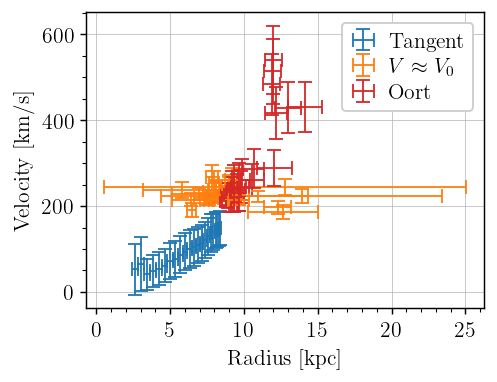

In [ ]:
R_tangent = np.array([nom_vals(R) for R in cloud_orbit_radii_t if R is not None])
err_R_tangent = np.array([std_devs(R) for R in cloud_orbit_radii_t if R is not None])
V_tangent = np.array([v.n for v in cloud_velocities_t if v is not None])
err_V_tangent = np.array([std_devs(v) for v in cloud_velocities_t if v is not None])

R_vector_const = np.array([nom_vals(R) for R in cloud_orbit_radii_v_const if R is not None])
err_R_vector_const = np.array([std_devs(R) for R in cloud_orbit_radii_v_const if R is not None])
V_vector_const = np.array([v.n for v in cloud_velocities_v_const if v is not None])
err_V_vector_const = np.array([std_devs(v) for v in cloud_velocities_v_const if v is not None])

R_vector_oort = np.array([nom_vals(R) for R in cloud_orbit_radii_v_oort if R is not None])
err_R_vector_oort = np.array([std_devs(R) for R in cloud_orbit_radii_v_oort if R is not None])
V_vector_oort = np.array([v.n for v in cloud_velocities_v_oort if v is not None])
err_V_vector_oort = np.array([std_devs(v) for v in cloud_velocities_v_oort if v is not None])


longitudes_array = np.array([l.n for l in (longitudes_t + longitudes_v_const + longitudes_v_oort) if l is not None])

cmap = plt.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=longitudes_array.min(), vmax=longitudes_array.max())
col_map=plt.cm.viridis((longitudes_array-min(longitudes_array))/(max(longitudes_array)-min(longitudes_array)))

for i in range(len(R_tangent)):
    plt.errorbar(R_tangent[i], V_tangent[i],
                xerr=err_R_tangent[i], 
                yerr=err_V_tangent[i],
                ecolor='C0', ls='')
    plt.errorbar(R_vector_const[i], V_vector_const[i],
                xerr=err_R_vector_const[i], 
                yerr=err_V_vector_const[i],
                ecolor='C1', ls='')
    plt.errorbar(R_vector_oort[i], V_vector_oort[i],
                xerr=err_R_vector_oort[i], 
                yerr=err_V_vector_oort[i],
                ecolor='C3', ls='')
    
ax=plt.gca() #get the current axes
    

# plt.scatter([nom_vals(R) for R in cloud_orbit_radii_t if R is not None], [v.n / 1000 for v in cloud_velocities_t if v is not None], c=[l.n for l in longitudes if l is not None], label='tangent')
# plt.scatter([nom_vals(R) for R in cloud_orbit_radii_v if R is not None], [v.n / 1000 for v in cloud_velocities_v if v is not None], c=[l.n for l in longitudes if l is not None], marker='x', label='vector')
plt.xlabel('Radius [kpc]')
plt.ylabel('Velocity [km/s]')
plt.legend(["Tangent", r"$V \approx V_0$", "Oort"])
# plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label=r"$\ell$", ax=ax)

# plt.tight_layout()
plt.savefig("../figures/VEGA2_velocity_curve.pdf")

## What are we looking at???

In [21]:
def distance_fuckery(relative_velocity: float, radius: float, galactic_longitude: float, fuck: str) -> float:
    galactic_rad = deg2rad(galactic_longitude)

    if fuck == 'tan':
        pass
        
    f = radius**2 - (R0 * unp.sin(galactic_rad))**2

    if f < 0:
        return bad_distance_estimate(relative_velocity, galactic_longitude)
    elif f.n == 0:
        return R0 * unp.cos(galactic_rad)
    else:
        a = f ** 0.5
        b = R0 * unp.cos(galactic_rad)
        dplus = a + b
        dminus = b - a
        if galactic_longitude < 90:
            return dminus
        else:
            return dplus

In [22]:
idx_t = slice(0,len(cloud_orbit_radii_t))
idx_v_const = slice(len(cloud_orbit_radii_t), len(cloud_orbit_radii_t) + len(cloud_orbit_radii_v_const))
idx_v_oort = slice(len(cloud_orbit_radii_t) + len(cloud_orbit_radii_v_const), len(cloud_orbit_radii_t) + len(cloud_orbit_radii_v_const) + len(cloud_orbit_radii_v_oort))
radii_array = np.concat([cloud_orbit_radii_t, cloud_orbit_radii_v_const, cloud_orbit_radii_v_oort])
vel_array = np.concat([cloud_velocities_t, cloud_velocities_v_const, cloud_velocities_v_oort])

# bad_distances = bad_distance_estimate(np.array([v.n for v in velocities_vector if v is not None]), longitudes_array)
less_bad_distances_plus = np.concat(
    [
        # Tangent
        # R0 * unp.cos(longitudes_array[idx_t]),
        (cloud_velocities_t - V0 * unp.sin(longitudes_array[idx_t])) / OORT_A / unp.sin(2 * longitudes_array[idx_t]),
        # V \approx V_0
        R0 * V0 
    ]
)
# less_bad_distances_minus = R0 * unp.cos(deg2rad(longitudes_array)) - unp.sqrt(R0**2 * unp.cos(deg2rad(longitudes_array))**2 - (R0**2 - radii_array**2))

# MODIFY THIS AFTER NEW DATA 
# less_bad_distances_plus = np.delete(less_bad_distances_plus, -4)
# longitudes_array = np.delete(longitudes_array, -4)

with mpl.rc_context():
    mpl.rcParams['savefig.bbox'] = 'standard'
    mpl.rcParams["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM)
    mpl.rcParams["figure.subplot.left"]   = 0.05
    mpl.rcParams['figure.subplot.right']  = 0.99
    mpl.rcParams['figure.subplot.top']    = 0.97
    mpl.rcParams['figure.subplot.bottom'] = 0.12

    ax = plt.subplot(projection="polar")

    # plt.scatter(deg2rad(longitudes_array), less_bad_distances_plus, marker='+')
    plt.errorbar(deg2rad(longitudes_array[idx_t]), nom_vals(less_bad_distances_plus[idx_t]),
                 yerr=std_devs(less_bad_distances_plus[idx_t]), ls='', capsize=1.5, label='Tangent')
    plt.errorbar(deg2rad(longitudes_array[idx_v_const]), nom_vals(less_bad_distances_plus[idx_v_const]),
                 yerr=std_devs(less_bad_distances_plus[idx_v_const]), ls='', capsize=1.5, label=r'$V \approx V_0$')
    plt.errorbar(deg2rad(longitudes_array[idx_v_oort]), nom_vals(less_bad_distances_plus[idx_v_oort]),
                 yerr=std_devs(less_bad_distances_plus[idx_v_oort]), ls='', capsize=1.5, label='Oort')
    plt.scatter(0, R0, label="Center of galaxy", marker='d', c="C1")

    # Position of galactic center
    circle = plt.Circle((R0, 0), R0, transform=ax.transData._b, facecolor=None, fill=False, ls='--', color="#a0a0a0", zorder=0, lw=0.75)
    ax.add_patch(circle)


    plt.yticks([4,8,12, 16])
    ax.set_rlabel_position(315)
    
    plt.legend(loc='lower left')
    plt.savefig("../figures/VEGA2_galaxy_map.pdf")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)